In [20]:
import numpy as np

from scipy.spatial.distance import cosine

from env import YoutubeEnv
import matplotlib.pyplot as plt

In [2]:
seed = 420
env = YoutubeEnv.random_env(seed=seed)

In [3]:
env

In [4]:
u = env.users[0]
c = env.channels[0]
for v in c.videos:
    print("v = ", v)
    print(u.watch(v))

v =  <videos.Video object at 0x10a990780>
0.0
v =  <videos.Video object at 0x161910a1d0>
0.2900855975033973
v =  <videos.Video object at 0x161910a320>
0.29881616163884406


In [5]:
model_param = list(env.videos.values())

In [9]:
def eps_greedy(nb_tries, cum_rewards, param):
    if param == None:
        eps = 0.1
    else:
        eps = float(param)
    k = np.shape(nb_tries)[0]
    if np.sum(nb_tries) == 0 or np.random.random() < eps:
        return np.random.randint(k)
    else:
        index = np.where(nb_tries > 0)[0]
        return index[np.argmax(cum_rewards[index] / nb_tries[index])]

In [10]:
def get_reward(user, video):
    return user.watch(video)

In [11]:
def simulate(algo, model_param, user, param = None, time_horizon = 500):
    k = len(model_param)
    nb_tries = np.zeros(k, int)
    cum_rewards = np.zeros(k, float)
    action_seq = []
    reward_seq = []
    for t in range(time_horizon):
        a = algo(nb_tries, cum_rewards, param)
        r = get_reward(user, model_param[a])
        nb_tries[a] += 1
        cum_rewards[a] += r
        action_seq.append(a)
        reward_seq.append(r)
    index = np.where(nb_tries > 0)[0]
    best_action = index[np.argmax(cum_rewards[index] / nb_tries[index])]
    print("Best action (estimation) = ", best_action)
    print("Average reward of this action = ", cum_rewards[best_action] / nb_tries[best_action])
    return action_seq, reward_seq

In [12]:
def get_best_action(user, model_param):
    best_action, best_reward = (0, 0)
    for i in range(len(model_param)):
        rew = user.watch(model_param[i])
        if rew > best_reward:
            best_action = i
            best_reward = rew
    return best_action, best_reward

In [21]:
def cosine_sim(u, v):
    """ Redefine cosine distance as cosine similarity, with numerical stability """
    sim = 1 - cosine(u, v)
    epsilon = 10e-8
    sim = max(epsilon, sim)
    sim = min(1 - epsilon, sim)
    return sim

In [22]:
def get_best_action_sim(user, model_param):
    best_action, best_sim = (0, 0)
    for i in range(len(model_param)):
        sim = cosine_sim(user.keywords, model_param[i].keywords)
        if sim > best_sim:
            best_action = i
            best_sim = sim
    return best_action, best_sim

In [13]:
def get_regret(action_seq, reward_seq, best_actions, best_reward):
    time_horizon = len(action_seq)
    regret = np.zeros(time_horizon, float)
    precision = np.zeros(time_horizon, float)
    for t in range(time_horizon):
        regret[t] = best_reward - reward_seq[t]
    return np.cumsum(regret), precision

In [14]:
def show_metrics(metrics, time_horizon):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Regret')
    ax1.plot(range(time_horizon),metrics[0], color = 'b')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Precision')
    ax2.set_ylim(-0.02,1.02)
    ax2.plot(range(time_horizon),metrics[1], color = 'b')
    plt.show()

Best action (estimation) =  4
Average reward of this action =  0.41095005915988325


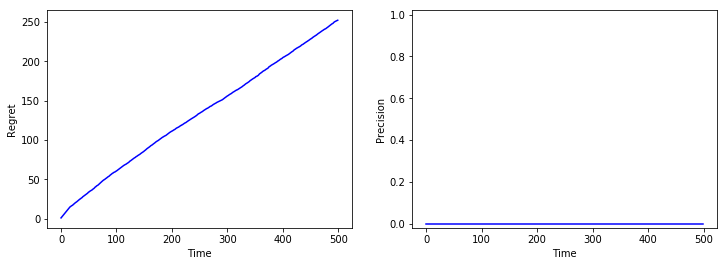

In [29]:
results = simulate(eps_greedy, model_param, u)
regret = get_regret(*results, *get_best_action(u, model_param))
show_metrics(regret, 500)

In [16]:
get_best_action(u, model_param)

(26, 0.6425196742444891)

In [23]:
get_best_action_sim(u, model_param)

(10, 0.6405154155560805)